In [1]:
# Step 0. Load libraries and custom functions
# Matrices and datasets ------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Text processors
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
# Machine Learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
# Deep Learning --------------------------------------------------------
import keras
import tensorflow as tf
from keras import layers
from keras.layers import TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Custom functions -----------------------------------------------------
def sentence_fixed_split(x:list, words: int):
    """
    Split a list of sentences into a list of fixed length sentences.
    
    Parameters
    ----------
    x: list
        sentence as a list of words
    words: int 
        number of fixed words required

    Returns
    -------
    list
        a list of fixed length sentences

    Example
    -------
        df = pd.DataFrame({'text':['In our darkest hour, I will prevail as always']})
        df['text'] = df['text'].apply(lambda x: sentence_fixed_split(x, 4))
        df = df.explode('text')
        text
        ----
        In our darkest hour,
        I will prevail as
        always
    """
    words_lenght = len(x.split(' '))
    if words_lenght>1 and words > 1 and words_lenght > words:
        return [' '.join(x.split(' ')[i:i+words]) for i in range(0, len(x.split(' ')), words)]
    else:
        return x

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexismena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Step 1. Load data
# 1.1 Read csv and get basic info
df_train = pd.read_csv('../data/01_IMDB_Train.csv')
df_val = pd.read_csv('../data/01_IMDB_Valid.csv')
df_test = pd.read_csv('../data/01_IMDB_Test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [3]:
# 1.2 Get a sample
df_train.sample(10, random_state=2024)

,text,label
784,Trilogies are very interesting. Some go out wi...,1
6741,I think that this film was one of Kurt Russels...,1
27783,This movie is Jackie's best. I still cant get ...,1
33345,There were at least a half dozen silent-film v...,1
37106,This is easily my favourite film. A tragic rom...,1
18838,"I saw this film at the Toronto Film Festival, ...",1
12246,** possible spoilers **<br /><br />I like this...,1
5345,"When I went to the video rental store, back in...",1
19571,I saw this short film on the dvd for Ridley Sc...,0
23939,I read some gushing reviews here on IMDb and t...,0


In [4]:
# 1.3 Verify if there are duplicates
df_train['text'].duplicated().sum()

277

In [5]:
# 1.4 Preprocess data based on observed information
df_train = df_train[~df_train.text.duplicated()]
df_val = df_val[~df_val.text.duplicated()]
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [6]:
# Step 2. Create a basic analysis
# 2.1 Get basic info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39723 entries, 0 to 39722
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39723 non-null  object
 1   label   39723 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 620.8+ KB


In [7]:
# 2.2 Get a summary of the data
df_train.describe(include='all')

,text,label
count,39723,39723.000000
unique,39723,NaN
top,I grew up (b. 1965) watching and loving the Th...,NaN
freq,1,NaN
mean,NaN,0.501171
std,NaN,0.500005
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [8]:
# 2.3 Get words statistics
df_train['text'].apply(lambda x: len(x.split())).describe()

count    39723.000000
mean       231.486142
std        171.367657
min          4.000000
25%        126.000000
50%        173.000000
75%        282.000000
max       2470.000000
Name: text, dtype: float64

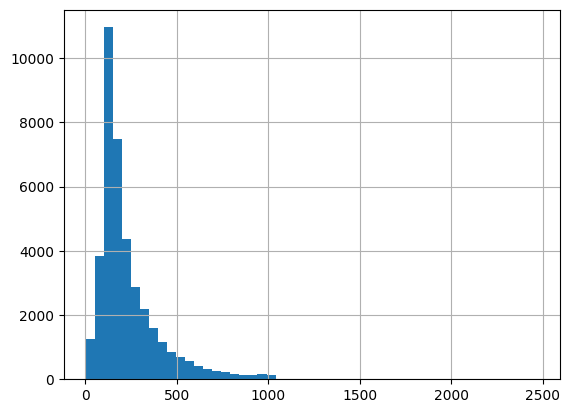

In [9]:
# 2.4 Show histogram of word count
df_train['text'].apply(lambda x: len(x.split(' '))).hist(bins=50)
plt.show()

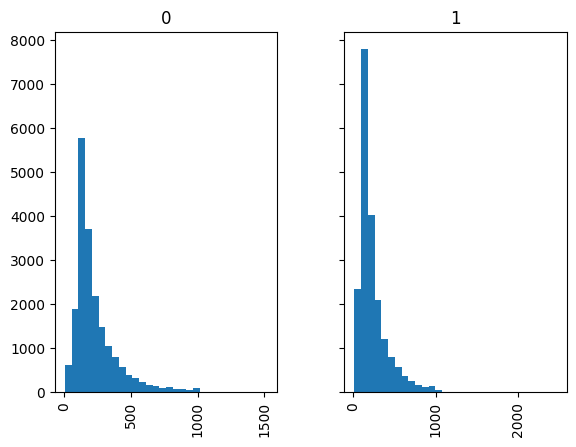

In [10]:
# 2.5 Show histogram of word count stratified by sentiment
(df_train
 .assign(word_count = df_train['text'].apply(lambda x: len(x.split())))
 .hist('word_count', by='label', sharey=True, bins=30)
)
plt.show()

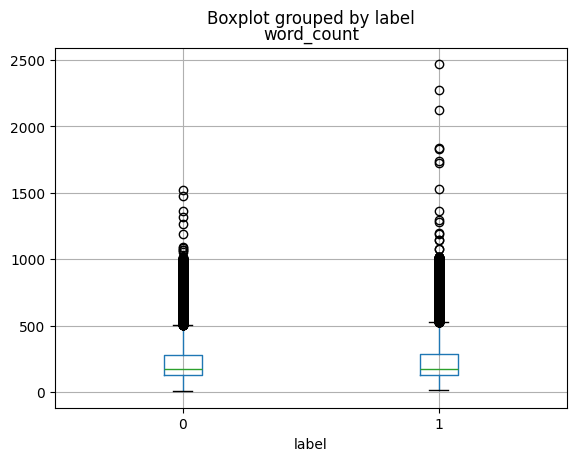

In [11]:
# 2.6 Show boxplot of word count stratified by sentiment
(df_train
 .assign(word_count = df_train['text'].apply(lambda x: len(x.split())))
 .boxplot('word_count', by='label')
)
plt.show()

In [12]:
# 2.7 List total words in our vocabulary
df_train['text'].str.split(expand=True).stack().value_counts().count()

381542

In [13]:
# 2.8 List most frequent words in reviews
df_train['text'].str.split(expand=True).stack().value_counts()[:20]

the      452256
a        244575
and      240627
of       225606
to       208322
is       161625
in       134916
I        105373
that     100888
this      90419
it        86062
/><br     80215
was       73678
as        66287
with      65521
for       64469
The       53448
but       52912
on        48626
movie     48440
Name: count, dtype: int64

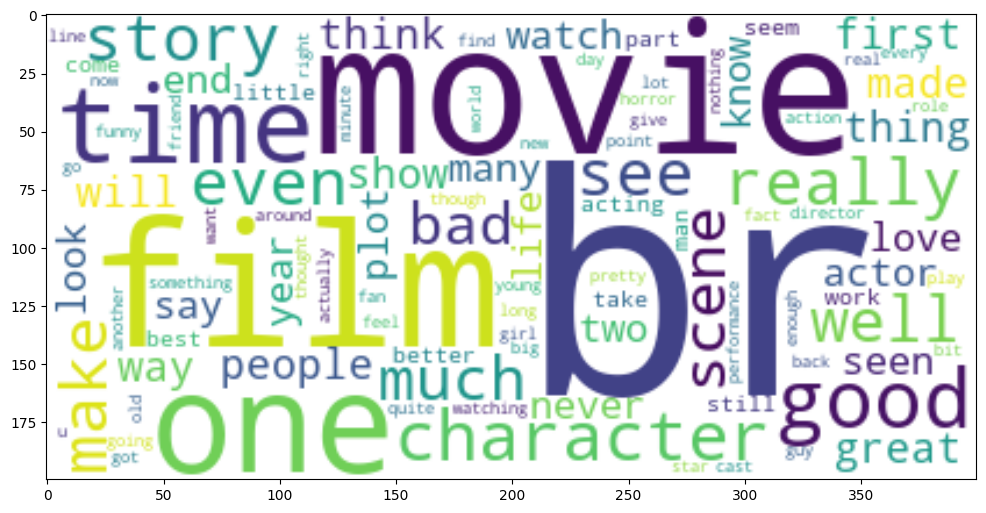

In [14]:
# 2.9 View the wordcloud of reviews without stopwords
text = ' '.join(i.lower() for i in df_train['text'])
wordcloud = WordCloud(max_words=100, 
                      stopwords=None, 
                      background_color='White', 
                      collocations=False).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

After analyzing the dataset, we need to create a processing pipeline that:
- removes stopwords
- removes html tags
- removes punctuations
- uses a compact vocabulary
- lowercases the words
- corrects mispelled words like soooo, muuuuch, etc (more than 3 vowels)
- encode sentiment into 1 or 0 

For our traning task, we can split longest reviews into segments or just 
truncate the review up to 500 words and eliminate the rest, but it 
results in losing some information, so we will try both aproaches

In [15]:
# Step 3. Create a NN model iterations
################### Bag of words - Unigram case ########################
# 3.1 Create tensorflow dataset
def make_data(dataset):
    return tf.data.Dataset.from_tensor_slices(
        (
            {'text':dataset['text']},
            dataset['label']
        )
    )
train = make_data(df_train).batch(32)
val = make_data(df_val).batch(32)
test = make_data(df_test).batch(32)

2024-02-26 00:13:44.141395: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-02-26 00:13:44.141432: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-26 00:13:44.141442: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-26 00:13:44.141473: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-26 00:13:44.141489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# 3.2 Create functions to process text on TF string tensors
def custom_standardization_fn(string_tensor):
    '''
    This function does remove blank spaces, lowercases the text, removes 
    html tags, reduces whitespaces, sets spaces after comma, replaces 
    tripple representations of vowels and removes punctuations 
    '''
    stripped_string = tf.strings.strip(string_tensor)
    lowercase_string = tf.strings.lower(stripped_string)
    tagless_string = tf.strings.regex_replace(lowercase_string, '<.*?>', '')
    single_space_string = tf.strings.regex_replace(tagless_string, '\s+',' ')
    comma_space_string = tf.strings.regex_replace(single_space_string, '\s,\s',', ')
    simple_vowel_a_string = tf.strings.regex_replace(comma_space_string, 'a{3,}', 'a')
    simple_vowel_e_string = tf.strings.regex_replace(simple_vowel_a_string, 'e{3,}', 'e')
    simple_vowel_i_string = tf.strings.regex_replace(simple_vowel_e_string, 'i{3, }', 'i')
    simple_vowel_o_string = tf.strings.regex_replace(simple_vowel_i_string, 'o{3, }', 'o')
    simple_vowel_u_string = tf.strings.regex_replace(simple_vowel_o_string, 'u{3, }', 'u')
    stripped_string_again = tf.strings.strip(simple_vowel_u_string)
    return tf.strings.regex_replace(stripped_string_again,
                                    f"[{re.escape(string.punctuation)}]",'')

def custom_split_fn(string_tensor):
    '''
    This function splits the string tensor
    '''
    return tf.strings.split(string_tensor)

In [17]:
# 3.3 Create the vectorization layer and function adapted to train
def create_vectorize_layer(train, feature):
    vectorize_layer = TextVectorization(
        standardize=custom_standardization_fn,
        split=custom_split_fn,
        max_tokens=20000,
        output_mode='count',
        #output_sequence_length=20000
    )
    vectorize_layer.adapt(train.map(lambda x, y: x[feature]))
    return vectorize_layer

vectorize_text = create_vectorize_layer(train, 'text')

2024-02-26 00:13:44.266075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [18]:
# 3.4 Expand the tf datasets applying vectorization
binary_1gram_train_ds = train.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_1gram_val_ds = val.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_1gram_test_ds = test.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

for inputs, targets in binary_1gram_train_ds:
    print('Inputs.shape', inputs.shape)
    print('Targets.shape', targets.shape)
    print('Inputs[0]', inputs[0])
    print('Targets[0]', targets[0])
    break

Inputs.shape (32, 20000)
Targets.shape (32,)
Inputs[0] tf.Tensor([7. 7. 3. ... 0. 0. 0.], shape=(20000,), dtype=float32)
Targets[0] tf.Tensor(0, shape=(), dtype=int64)


In [19]:
# 3.5 Create the model, nn architecture and callback, printing the model
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoints/01_model_binary_1gram.keras',
                                    save_best_only=True)
]
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# 3.6 Train the model
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

Epoch 1/10
1242/1242 [==============================] - 13s 10ms/step - loss: 0.3681 - accuracy: 0.8487 - val_loss: 0.2813 - val_accuracy: 0.8882
Epoch 2/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.2381 - accuracy: 0.9131 - val_loss: 0.2768 - val_accuracy: 0.8936
Epoch 3/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1966 - accuracy: 0.9311 - val_loss: 0.2910 - val_accuracy: 0.8920
Epoch 4/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1747 - accuracy: 0.9409 - val_loss: 0.2953 - val_accuracy: 0.8932
Epoch 5/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1668 - accuracy: 0.9441 - val_loss: 0.3049 - val_accuracy: 0.8910
Epoch 6/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1633 - accuracy: 0.9449 - val_loss: 0.3086 - val_accuracy: 0.8912
Epoch 7/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1620 - accuracy: 0.9457 - val_loss: 0.3098 -

In [21]:
# 3.7 Evaluate the model on the test dataset
model = keras.models.load_model('checkpoints/01_model_binary_1gram.keras')
print(f'Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}')

157/157 [==============================] - 1s 6ms/step - loss: 0.2824 - accuracy: 0.8978
Test acc: 0.898


In [22]:
################### Bag of words - Bigram case #########################
# 3.8 Create the vectorization layer and function adapted to train
def create_vectorize_layer(train, feature):
    vectorize_layer = TextVectorization(
        standardize=custom_standardization_fn,
        split=custom_split_fn,
        max_tokens=20000,
        output_mode='count',
        ngrams=2
        #output_sequence_length=20000
    )
    vectorize_layer.adapt(train.map(lambda x, y: x[feature]))
    return vectorize_layer

vectorize_text = create_vectorize_layer(train, 'text')

In [23]:
# 3.9 Expand the tf datasets applying vectorization
binary_2gram_train_ds = train.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_2gram_val_ds = val.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_2gram_test_ds = test.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

for inputs, targets in binary_2gram_train_ds:
    print('Inputs.shape', inputs.shape)
    print('Targets.shape', targets.shape)
    print('Inputs[0]', inputs[0])
    print('Targets[0]', targets[0])
    break

Inputs.shape (32, 20000)
Targets.shape (32,)
Inputs[0] tf.Tensor([119.   7.   3. ...   0.   0.   0.], shape=(20000,), dtype=float32)
Targets[0] tf.Tensor(0, shape=(), dtype=int64)


In [24]:
# 3.10 Create the model, nn architecture and callback, printing the model
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoints/01_model_binary_2gram.keras',
                                    save_best_only=True)
]
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# 3.11 Train the model
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

Epoch 1/10
1242/1242 [==============================] - 13s 10ms/step - loss: 0.5053 - accuracy: 0.7903 - val_loss: 0.2764 - val_accuracy: 0.8926
Epoch 2/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.2786 - accuracy: 0.8955 - val_loss: 0.2917 - val_accuracy: 0.8880
Epoch 3/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.2460 - accuracy: 0.9140 - val_loss: 0.2923 - val_accuracy: 0.8896
Epoch 4/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.2177 - accuracy: 0.9274 - val_loss: 0.2803 - val_accuracy: 0.8982
Epoch 5/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1938 - accuracy: 0.9369 - val_loss: 0.2984 - val_accuracy: 0.8934
Epoch 6/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1801 - accuracy: 0.9425 - val_loss: 0.2900 - val_accuracy: 0.8972
Epoch 7/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1684 - accuracy: 0.9470 - val_loss: 0.2910 -

In [26]:
# 3.12 Evaluate the model on the test dataset
model = keras.models.load_model('checkpoints/01_model_binary_2gram.keras')
print(f'Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}')

157/157 [==============================] - 1s 6ms/step - loss: 0.2728 - accuracy: 0.9006
Test acc: 0.901
